# Introduction

This project addresses the take-home challenge component of the data-science interview process for Relax, Inc. The thrust of the project is to identify factors that predict future user adoption, where user adoption is defined as logging into the product on three separate days in at least one seven-day period. 

# Data Wrangling

Here, I will read in the engagment dataset, check for missing values, and perform any other cleaning that might be needed.

In [168]:
import pandas as pd
import numpy as np

engage = pd.read_csv('takehome_user_engagement.csv')
engage.head(10)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
5,2013-12-31 03:45:04,2,1
6,2014-01-08 03:45:04,2,1
7,2014-02-03 03:45:04,2,1
8,2014-02-08 03:45:04,2,1
9,2014-02-09 03:45:04,2,1


In [169]:
#check number of unique users 
print(len(engage.user_id.unique()))

8823


In [54]:
# check for missing data -- none! 
print(engage.isnull().values.any())

False


In [55]:
# visited column appears to have no use at this point 
print(engage.visited.unique()) 

[1]


In [72]:
# drop visited column 
engage.drop(['visited'], axis=1, inplace=True)

In [75]:
# adjust df so that time stamp is index w/ monotonic increase
# mark adopted users (logged in 3 discrete days within a 7-day period)
engage['time_stamp'] = pd.to_datetime(engage['time_stamp'], format="%Y-%m-%d %H:%M:%S.%f", 
                                          exact=True, utc=True) # require exact format match; use UTC time
engage.index = pd.DatetimeIndex(engage.time_stamp, inplace=True) #make time stamp the index
eng_ind = engage.sort_index() #sort by index labels 
eng_ind.drop(eng_ind.columns[0], axis=1, inplace=True)

print (eng_ind.index.is_monotonic_increasing) # need monotonic increase to use rolling method in groupby
eng_ind.head()

True


,user_id
time_stamp,
2012-05-31 08:20:06,10012
2012-05-31 15:47:36,3428
2012-05-31 17:19:37,9899
2012-05-31 21:58:33,1693
2012-06-01 00:17:30,6102


In [125]:
# find adopted users (logged in on 3 different days in 7-day period)
adopt = eng_ind.groupby('user_id').rolling(window='7d', min_periods=3).sum().fillna(0)

In [126]:
# add column to flag adopted users (df does better w/ this step in separate cell)
adopt['adopted'] = np.where(adopt['user_id']>0, 1, 0)
adopt.rename(columns={'user_id': 'id'}, inplace=True) #create separate name for dropping later
adopt.head(10)

id  adopted
user_id time_stamp                       
1       2014-04-22 03:53:30  0.0        0
2       2013-11-15 03:45:04  0.0        0
        2013-11-29 03:45:04  0.0        0
        2013-12-09 03:45:04  0.0        0
        2013-12-25 03:45:04  0.0        0
        2013-12-31 03:45:04  0.0        0
        2014-01-08 03:45:04  0.0        0
        2014-02-03 03:45:04  0.0        0
        2014-02-08 03:45:04  0.0        0
        2014-02-09 03:45:04  6.0        1

In [152]:
#remove time-stamp part of index, drop defunct ID column
new_index = adopt.reset_index(0).reset_index(drop=True) 
new_index.drop(['id'], axis=1, inplace=True)
new_index.head(10)

,user_id,adopted
0,1,0
1,2,0
2,2,0
3,2,0
4,2,0
5,2,0
6,2,0
7,2,0
8,2,0
9,2,1


In [159]:
# group by user ID; 'adopted' value > 0 indicates adopted user
grouped = new_index.groupby('user_id').sum().reset_index()
grouped['adopted'] = np.where(grouped['adopted']>0, 1, 0)
grouped.head(10)

,user_id,adopted
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,10,1
8,11,0
9,13,0


In [170]:
#check for match with original number of unique users 
print(len(grouped.user_id.unique()))

8823


# Merge and Wrangle Further
With the adopted users identified, we are ready to merge the datasets so that all user information is in one dataframe. 

In [160]:
# read in users data set

users = pd.read_csv('takehome_users.csv', encoding='latin-1') #encoding handles UTF-8 need for appropriate bytes
users.rename(columns = {'object_id':'user_id'}, inplace = True) #change object_id to user_id for merge
users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [229]:
# merge data frames 
merged = users.merge(grouped, on='user_id', how='inner')
merged.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [183]:
# checks of dimensions
print('Users DF Dimensions: {}'.format(users.shape))
print('Grouped DF Dimensions: {}'.format(grouped.shape))
print('Merged DF Dimensions: {}'.format(merged.shape))
print()
print('Unique Users Initially: {}'.format(len(users.user_id.unique())))
print('Unique Users After Merge: {}'.format(len(merged.user_id.unique())))

Users DF Dimensions: (12000, 10)
Grouped DF Dimensions: (8823, 2)
Merged DF Dimensions: (8823, 11)

Unique Users Initially: 12000
Unique Users After Merge: 8823


In [184]:
# check for missing data -- problems in invited_by_user_id
print(merged.isnull().sum())

user_id                          0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time       0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            4047
adopted                          0
dtype: int64


Nearly half of the observations have no value for the inviting user. But we can still get some useful information from this variable, so there's no need to drop it outright.  I'm going to proceed on the assumption that this means that affected observations simply were not referred by another user in the first place. With that in said, I'll use this variable to create a new, binary column to indicate whether a user was referred or not. (The other option would be to drop the missing data, which would not be good with nearly half of the data missing a referral ID.) 

In [230]:
# create binary variable to indicate if user was referred
merged['referred'] = np.where(pd.isnull(merged['invited_by_user_id']), 0, 1)

In [300]:
# drop unneeded variables 
merged_drop = merged.drop(['invited_by_user_id', 'name', 'user_id', 'email'], axis=1)
merged_drop.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted,referred
0,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,11,0,1
1,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,1,1
2,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0,94,0,1
3,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0,1,0,1
4,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0,193,0,1


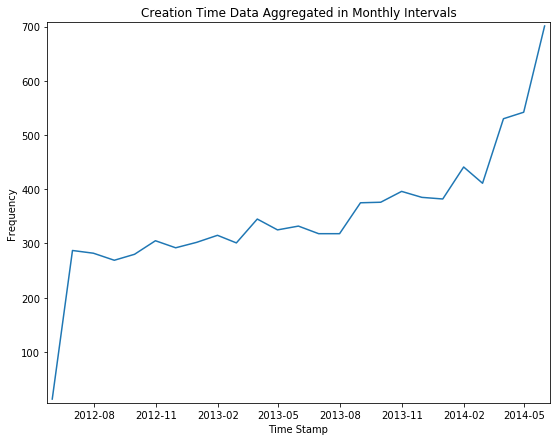

In [305]:
# plot creation time data 
ct_df = pd.DataFrame(pd.to_datetime(merged_drop['creation_time']))
ct_df.set_index('creation_time', inplace=True) 
ct_df['count'] = 1 
ct_agg = ct_df.resample('M').sum() 

plt.figure(figsize=(9, 7))
plt.plot(ct_agg)
plt.title('Creation Time Data Aggregated in Monthly Intervals')
plt.xlabel('Time Stamp')
plt.ylabel('Frequency')
plt.margins(0.01)
plt.show()
plt.show()

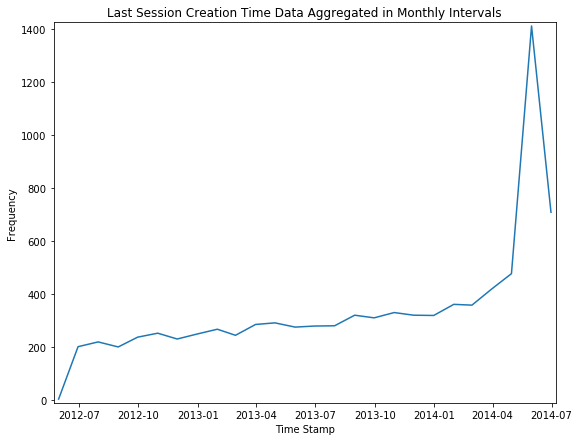

In [312]:
# plot last session data 
ls_df = pd.DataFrame(pd.to_datetime(merged_drop['last_session_creation_time'], unit='s'))
ls_df.set_index('last_session_creation_time', inplace=True) 
ls_df['count'] = 1 
ls_agg = ls_df.resample('M').sum() 

plt.figure(figsize=(9, 7))
plt.plot(ls_agg)
plt.title('Last Session Creation Time Data Aggregated in Monthly Intervals')
plt.xlabel('Time Stamp')
plt.ylabel('Frequency')
plt.margins(0.01)
plt.show()
plt.show()

In [313]:
# capture month and year of registration date; convert last log-in time to month and year 

import datetime as dt
merged_drop['creation_time'] = pd.to_datetime(merged_drop['creation_time'])
merged_drop['creation_time'] = merged_drop['creation_time'].dt.to_period('M')
merged_drop['last_session_creation_time'] = pd.to_datetime(merged_drop['last_session_creation_time'], unit='s')
merged_drop['last_session_creation_time'] = merged_drop['last_session_creation_time'].dt.to_period('M')
merged_drop.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted,referred
0,2014-04,GUEST_INVITE,2014-04,1,0,11,0,1
1,2013-11,ORG_INVITE,2014-03,0,0,1,1,1
2,2013-03,ORG_INVITE,2013-03,0,0,94,0,1
3,2013-05,GUEST_INVITE,2013-05,0,0,1,0,1
4,2013-01,GUEST_INVITE,2013-01,0,0,193,0,1


When viewed by month, both registrations and last log-in times increase in frequency, but they do so in somewhat different fashions. Last-session times, in particular, show a significant spike in the final few months. 

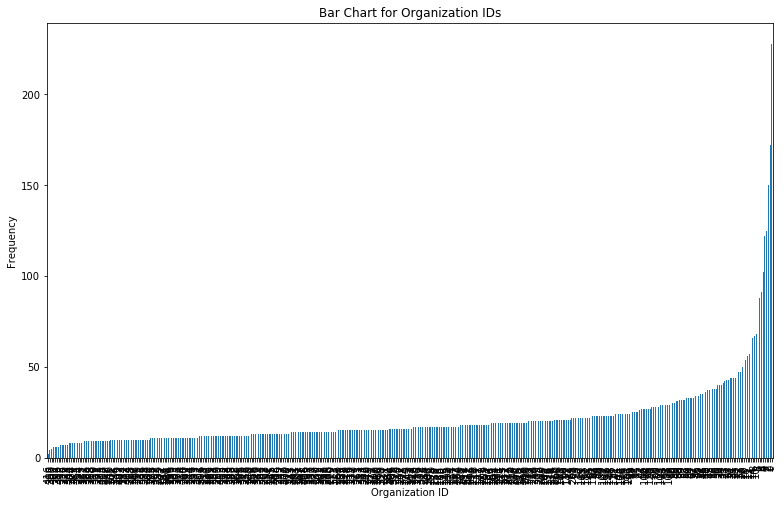

In [278]:
# plot last log-in times (417 different ones exist)
import mpld3

mpld3.enable_notebook() #enables zooming and scrolling within charts
plt.figure(figsize=(13, 8))

merged_drop.org_id.value_counts(ascending = True).plot(kind = "bar")
plt.title('Bar Chart for Organization IDs')
plt.xlabel('Organization ID')
plt.ylabel('Frequency')
plt.show()

mpld3.disable_notebook()

Most users are clustered into a relatively low number of organizations. Through the use of the zooming functionality in the plot above, one sees that these are organizations with low ID numbers, too. Without additional information, I cannot comment on what types of organizations these might be or why more people are them. But it will be interesting to see if this variable has predictive value nonetheless. 

In [321]:
# check unique values in new categorical variables for sake of total-variable count w/ dummies
print(len(merged_drop.creation_time.unique()))
print(len(merged_drop.last_session_creation_time.unique()))
print(len(merged_drop.org_id.unique()))

25
26
417


After one-hot encoding is done, we will have a few hundred more variables. But the ratio of variables to observations will still be lower than 1:10, so it should not present a serious problem.

In [268]:
# check balance of dependent variable
print(merged_drop['adopted'].value_counts())

0    7221
1    1602
Name: adopted, dtype: int64


There is notable imbalance in the dependent variable, so we'll likely need to address this during final analysis. 

In [272]:
#balance for other independent variables

cols = [merged_drop['creation_source'], merged_drop['opted_in_to_mailing_list'], 
        merged_drop['enabled_for_marketing_drip'], merged_drop['referred']]

for col in cols:
    print(col.name)
    print(col.value_counts())
    print()

creation_source
ORG_INVITE            3188
SIGNUP                1898
GUEST_INVITE          1588
SIGNUP_GOOGLE_AUTH    1385
PERSONAL_PROJECTS      764
Name: creation_source, dtype: int64

opted_in_to_mailing_list
0    6597
1    2226
Name: opted_in_to_mailing_list, dtype: int64

enabled_for_marketing_drip
0    7482
1    1341
Name: enabled_for_marketing_drip, dtype: int64

referred
1    4776
0    4047
Name: referred, dtype: int64



In [317]:
# one-hot encoding to create binaries for each level of categorical variables
cols = ['creation_time', 'creation_source', 'last_session_creation_time', 'org_id']

one_hot = pd.get_dummies(merged_drop, columns = cols, drop_first = True) 
one_hot.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted,referred,creation_time_2012-06,creation_time_2012-07,creation_time_2012-08,creation_time_2012-09,creation_time_2012-10,creation_time_2012-11,...,org_id_407,org_id_408,org_id_409,org_id_410,org_id_411,org_id_412,org_id_413,org_id_414,org_id_415,org_id_416
0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [328]:
# check dimensions of new df
one_hot.shape

(8823, 473)

# Model: Logistic Regression

In order to identify which factors predict future user adoption, I will use a logistic regression. This type of model generally works well in classification problems like this one, and it also provides coefficients for each variable. These coefficients will help identify which predictors have the most predictive value. 

In [329]:
# capture independent variables in list
features = list(one_hot)
features = [e for e in features if e not in ('adopted')]

In [333]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore') 

# train, test, split
X = one_hot[features].values
y = one_hot.adopted.values
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = .2, random_state = 11, stratify = y)

# standard scaling (mean of zero, unit variance) 
scaler = StandardScaler() 
X_train = scaler.fit_transform(Xtrain)
X_test = scaler.transform(Xtest)

In [335]:
# logistic regression, initial model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression()
clf.fit(Xtrain, Ytrain)

x_pred = clf.predict(Xtest) #capture predictions for Y based on data in X
accuracy_score(x_pred, Ytest) #print accuracy for test data

0.94787535410764867

In [336]:
# confusion matrix for test data
actual = pd.Series(Ytest, name = 'Actual')
predicted = pd.Series(x_pred, name = 'Predicted') 
test_ct = pd.crosstab(actual, predicted, margins = True) 
print(test_ct)

Predicted     0    1   All
Actual                    
0          1429   16  1445
1            76  244   320
All        1505  260  1765


The model looks okay to start, but I'll try improving it through tuning some parameters in the logistic regression model. 

In [338]:
from sklearn.model_selection import GridSearchCV

C_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]} 
weights = {0: .2, 1: .8} # class weights to address imbalance of dependent variable 
clf_grid = GridSearchCV(LogisticRegression(penalty='l2', class_weight = weights), C_grid, 
                        cv = 5, scoring = 'accuracy') 
clf_grid.fit(Xtrain, Ytrain) 

print(clf_grid.best_params_, clf_grid.best_score_) #output best C and best accuracy score

{'C': 100} 0.955653159535


In [339]:
# check model accuracy on training data 
clf_grid_best = LogisticRegression(C = clf_grid.best_params_['C'], penalty='l2', 
                                    class_weight = weights)
clf_grid_best.fit(Xtrain, Ytrain)

x_pred_train = clf_grid_best.predict(Xtrain) 
accuracy_score(x_pred_train, Ytrain)

0.97534712383111366

In [342]:
# confusion matrix 
actual_train_grid = pd.Series(Ytrain, name = 'Actual')
predict_train_grid = pd.Series(x_pred_train, name = 'Predicted') 
grid_train_ct = pd.crosstab(actual_train_grid, predict_train_grid, margins = True) 
print(grid_train_ct)

Predicted     0     1   All
Actual                     
0          5650   126  5776
1            48  1234  1282
All        5698  1360  7058


In [343]:
TN_train = grid_train_ct.iloc[0,0] / grid_train_ct.iloc[0,2]
TP_train = grid_train_ct.iloc[1,1] / grid_train_ct.iloc[1,2]
print('Training accuracy for non-adopted: {}'.format('%0.3f' % TN_train))
print('Training accuracy for adopted (Recall): {}'.format('%0.3f' % TP_train))

Training accuracy for non-adopted: 0.978
Training accuracy for adopted (Recall): 0.963


In [340]:
# check model accuracy on test data 
clf_grid_best.fit(Xtest, Ytest)
x_pred_test = clf_grid_best.predict(Xtest)
accuracy_score(x_pred_test, Ytest)

0.98526912181303117

In [344]:
# confusion matrix 
test_grid = pd.Series(Ytest, name = 'Actual')
pred_grid = pd.Series(x_pred_test, name = 'Predicted') 
grid_test_ct = pd.crosstab(test_grid, pred_grid, margins = True) 
print(grid_test_ct)

Predicted     0    1   All
Actual                    
0          1425   20  1445
1             6  314   320
All        1431  334  1765


In [345]:
TN_test = grid_test_ct.iloc[0,0] / grid_train_ct.iloc[0,2]
TP_test = grid_test_ct.iloc[1,1] / grid_train_ct.iloc[1,2]
print('Test accuracy for non-adopted: {}'.format('%0.3f' % TN_train))
print('Test accuracy for adopted (Recall): {}'.format('%0.3f' % TP_train))

Test accuracy for non-adopted: 0.978
Test accuracy for adopted (Recall): 0.963


In [348]:
# feature evaluation for logistic regression
logistic_coefs = clf_grid_best.coef_[0]
logistic_coef_df = pd.DataFrame({'feature': features, 'coefficient': logistic_coefs})
logistic_df = logistic_coef_df.sort_values('coefficient', ascending = False)
logistic_df.head(10)

,coefficient,feature
55,14.542737,last_session_creation_time_2014-06
54,12.969305,last_session_creation_time_2014-05
3,10.321495,creation_time_2012-06
53,9.147000,last_session_creation_time_2014-04
137,9.097680,org_id_82
174,8.651756,org_id_119
303,8.217541,org_id_248
7,7.472719,creation_time_2012-10
5,7.261015,creation_time_2012-08
51,6.866192,last_session_creation_time_2014-02


In [ ]:
# future work
 # other algorithms for classification
 # trying model with reduced #vars
    # bin org IDs when I have necessary business info to do so; or drop IDs w/ few obs 
        #-- explain being hamstrung andwhy left as is here
    # consider organizing dates by season rather than by month